<a href="https://colab.research.google.com/github/kerim371/Julia-Devito-Inversion-JUDI-examples-in-Colab/blob/main/JUDI_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To run this notebook in Colab you either have to use this script or download it and then upload to Colab. You cannot simply copy this code and past it to your Colab session - this won't let you use Julia. You can open **.pynb** document in textual editor and see at top of the document how it Julia is et up and change its version as well if you need.

# Julia installation

In [1]:
# Julia installation
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.5/julia-1.5.0-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

--2020-12-12 00:13:32--  https://julialang-s3.julialang.org/bin/linux/x64/1.5/julia-1.5.0-linux-x86_64.tar.gz
Resolving julialang-s3.julialang.org (julialang-s3.julialang.org)... 151.101.2.49, 151.101.66.49, 151.101.130.49, ...
Connecting to julialang-s3.julialang.org (julialang-s3.julialang.org)|151.101.2.49|:443... connected.
HTTP request sent, awaiting response... 302 gce internal redirect trigger
Location: https://storage.googleapis.com/julialang2/bin/linux/x64/1.5/julia-1.5.0-linux-x86_64.tar.gz [following]
--2020-12-12 00:13:33--  https://storage.googleapis.com/julialang2/bin/linux/x64/1.5/julia-1.5.0-linux-x86_64.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105098627 (100M) [application/x-tar]
Saving to: ‘/tmp/julia.tar.gz’

/tmp/julia.tar.gz   100%[=========

# JUDI and DEVITO installation

In [ ]:
!git clone https://github.com/slimgroup/JUDI.jl

In [ ]:
cd JUDI.jl

In [ ]:
!git checkout v2.2.0

In [ ]:
!pip install docu # models for python used by JUDI
!pip install devito matplotlib # or `pip3 install --user devito matplotlib`

In [ ]:
import os
os.environ['PYTHON'] = '/usr/local/bin/python'

!set ENV["PYTHON"] = '/usr/local/bin/python'

!julia -e 'using Pkg; Pkg.add("Pkg")'
!julia -e 'using Pkg; Pkg.Registry.add(RegistrySpec(url="https://github.com/slimgroup/SLIMregistryJL.git"))'
!julia -e 'using Pkg; Pkg.develop("JUDI")'

'cd ' command should be in separated cell

In [ ]:
cd ~/.julia/dev/JUDI

In [ ]:
!julia deps/install_global.jl
#!julia --project -e 'using Pkg;Pkg.test(coverage=false)' # uncomment this if you want to run test

# JUDI examples

Until now we have been using ipython. Now we are going to use Julia. To achieve it go to Colab's menu bar and select **Edit** and select **Notebook settings** from the drop down. Select *Julia 1.5.0* as the runtime and *GPU* as the hadware accelerator. If necessary reload web-page (F5) and change **Notebook settings**

## JUDI set python env var in Julia and install required packages

In [3]:
using Pkg
ENV["PYTHON"]="/usr/local/bin/python"
Pkg.build("PyCall")
#exit()

   Building Conda ─→ `~/.julia/packages/Conda/x5ml4/deps/build.log`
   Building PyCall → `~/.julia/packages/PyCall/BcTLp/deps/build.log`


In [3]:
; cd /content/JUDI.jl/examples/scripts

/content/JUDI.jl/examples/scripts


In [9]:
using Pkg

# IO
Pkg.add("HDF5")
Pkg.add("JLD")
Pkg.add("JLD2")

# Plotting
Pkg.add("PyPlot")

# Optimization
Pkg.add("NLopt")
Pkg.add("IterativeSolvers")
Pkg.add("Optim")
Pkg.add("LineSearches")
Pkg.add("SetIntersectionProjection")

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/

## Script examples

### extended_source_lsqr.jl

In [5]:
# Example for basic 2D modeling:
# The receiver positions and the source wavelets are the same for each of the four experiments.
# Author: Philipp Witte, pwitte@eos.ubc.ca
# Date: January 2017
#

using JUDI.TimeModeling, SegyIO, LinearAlgebra, PyPlot, IterativeSolvers, JOLI

# Set up model structure
n = (120, 100)   # (x,y,z) or (x,z)
d = (10., 10.)
o = (0., 0.)

# Velocity [km/s]
v = ones(Float32,n) .+ 0.4f0
v[:,Int(round(end/2)):end] .= 5f0

# Slowness squared [s^2/km^2]
m = (1f0 ./ v).^2

# Setup info and model structure
nsrc = 1	# number of sources
model = Model(n, d, o, m)

# Set up receiver geometry
nxrec = 120
xrec = range(50f0, stop=1150f0, length=nxrec)
yrec = 0f0
zrec = range(50f0, stop=50f0, length=nxrec)

# receiver sampling and recording time
time = 2000f0   # receiver recording time [ms]
dt = 4f0    # receiver sampling interval [ms]

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dt, t=time, nsrc=nsrc)

# Source wavelet
f0 = 0.01f0     # MHz
wavelet = ricker_wavelet(time, dt, f0)

# Set up info structure for linear operators
ntComp = get_computational_nt(recGeometry, model)
info = Info(prod(n), nsrc, ntComp)

LoadError: ignored

In [6]:
# Write shots as segy files to disk
opt = Options()

# Setup operators
Pr = judiProjection(info, recGeometry)
F = judiModeling(info, model; options=opt)

# Random weights (size of the model)
w = judiWeights(randn(Float32, model.n))

# Create operator for injecting the weights, multiplied by the provided wavelet(s)
Pw = judiLRWF(info, wavelet)

# Model observed data w/ extended source
lambda = 1f2
I = joDirac(info.n, DDT=Float32, RDT=Float32)
F = Pr*F*adjoint(Pw)
F̄ = [F; lambda*I]

# Simultaneous observed data
d_sim = F*w

# # Adjoint operation
w_adj = adjoint(F)*d_sim

# # LSQR
w_inv = 0f0 .* w
w_inv_no_damp = 0f0 .* w
lsqr!(w_inv, F̄, [d_sim; lambda*w]; maxiter=2, verbose=true, damp=1e2)
lsqr!(w_inv_no_damp, F, d_sim; maxiter=2, verbose=true, damp=1e2)

d_pred = F*w_inv;
d_pred_no_damp = F*w_inv_no_damp;

# Plot results
figure()
subplot(1,3,1)
imshow(d_sim.data[1], vmin=-5e2, vmax=5e2, cmap="gray"); title("Observed data")
subplot(1,3,2)
imshow(d_pred.data[1], vmin=-2e2, vmax=2e2, cmap="gray"); title("Predicted data")
subplot(1,3,3)
imshow(d_pred_no_damp.data[1], vmin=-2e2, vmax=2e2, cmap="gray"); title("Predicted data no damp")

LoadError: ignored

In [7]:
figure()
subplot(2,2,1)
imshow(w.weights[1], vmin=-3, vmax=3, cmap="gray"); title("Weights")
subplot(2,2,2)
imshow(w_adj.weights[1], vmin=minimum(w_adj), vmax=maximum(w_adj), cmap="gray"); title("Adjoint")
subplot(2,2,3)
imshow(w_inv.weights[1], vmin=minimum(w_inv), vmax=maximum(w_inv), cmap="gray"); title("D-LSQR")
subplot(2,2,4)
imshow(w_inv_no_damp.weights[1], vmin=minimum(w_inv), vmax=maximum(w_inv), cmap="gray"); title("LSQR")

LoadError: ignored

### fwi_example_2D.jl

In [ ]:
# 2D FWI on Overthrust model using minConf library
# Author: Philipp Witte, pwitte@eoas.ubc.ca
# Date: December 2017
#

using Statistics, Random, LinearAlgebra
using JUDI.TimeModeling, JUDI.SLIM_optim, HDF5, SegyIO, PyPlot

# Load starting model
n,d,o,m0 = read(h5open("../../data/overthrust_model.h5","r"), "n", "d", "o", "m0")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0)

# Bound constraints
v0 = sqrt.(1f0 ./ model0.m)
vmin = ones(Float32,model0.n) .* 1.3f0
vmax = ones(Float32,model0.n) .* 6.5f0
vmin[:,1:21] .= v0[:,1:21]   # keep water column fixed
vmax[:,1:21] .= v0[:,1:21]

# Slowness squared [s^2/km^2]
mmin = vec((1f0 ./ vmax).^2)
mmax = vec((1f0 ./ vmin).^2)

# Load data
block = segy_read("../../data/overthrust_shot_records.segy")
d_obs = judiVector(block)

# Set up wavelet
src_geometry = Geometry(block; key="source")
wavelet = ricker_wavelet(src_geometry.t[1],src_geometry.dt[1],0.008f0)  # 8 Hz wavelet
q = judiVector(src_geometry,wavelet)

┌ Info: Precompiling HDF5 [f67ccb44-e63f-5c2f-98bd-6dc0ccc4ba2f]
└ @ Base loading.jl:1278
┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=7076688, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /root/.julia/packages/SegyIO/uw4ZW/src/read/read_file.jl:26


judiVector{Float32}("Seismic data vector", 8016, 1, 16, GeometryIC(Any[400.0f0, 1013.333f0, 1626.667f0, 2240.0f0, 2853.333f0, 3466.666f0, 4080.0f0, 4693.334f0, 5306.666f0, 5920.0f0, 6533.334f0, 7146.666f0, 7760.0f0, 8373.333f0, 8986.667f0, 9600.0f0], Any[0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0], Any[50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0], Any[4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0], Any[501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501], Any[2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0]), Array[Float32[-0.00096925104; -0.0016848503; … ; -0.0; -0.0], Float32[-0.00096925104; -0.0016848503; … ; -0.0; -0.0], Float32[-0.00

In [ ]:
# Optimization parameters
niterations = 10
batchsize = 16
fhistory_SGD = zeros(Float32,niterations)

# Projection operator for bound constraints
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)]; dims=2),model0.n)

# Main loop
for j=1:niterations

    # get fwi objective function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0,q[i],d_obs[i])
    println("FWI iteration no: ",j,"; function value: ",fval)
    fhistory_SGD[j] = fval

	# linesearch
	step = backtracking_linesearch(model0, q[i], d_obs[i], fval, gradient, proj; alpha=1f0)

	# Update model and bound projection
	model0.m = proj(model0.m + reshape(step,model0.n))
end

LoadError: ignored

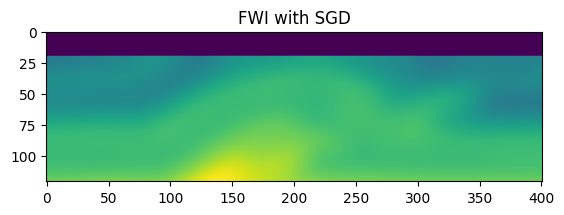

PyObject Text(0.5, 1.0, 'FWI with SGD')

In [ ]:
figure(); imshow(sqrt.(1f0./adjoint(model0.m))); title("FWI with SGD")

### fwi_example_NLopt.jl

In [ ]:
# 2D FWI on Overthrust model with L-BFGS using NLopt library
# Author: Philipp Witte, pwitte@eoas.ubc.ca
# Date: December 2017
#

using Statistics, Random, LinearAlgebra
using JUDI.TimeModeling, HDF5, NLopt, SegyIO

# Load starting model
n,d,o,m0 = read(h5open("../../data/overthrust_model.h5","r"), "n", "d", "o", "m0")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0)

# Bound constraints
v0 = sqrt.(1f0 ./ model0.m)
vmin = ones(Float32, model0.n) .* 1.3f0
vmax = ones(Float32, model0.n) .* 6.5f0

# Slowness squared [s^2/km^2]
mmin = vec((1f0 ./ vmax).^2)
mmax = vec((1f0 ./ vmin).^2)

# Load data
block = segy_read("../../data/overthrust_shot_records.segy")
d_obs = judiVector(block)

# Set up wavelet
src_geometry = Geometry(block; key="source")
wavelet = ricker_wavelet(src_geometry.t[1], src_geometry.dt[1], 0.008f0)    # 8 Hz wavelet
q = judiVector(src_geometry, wavelet)

┌ Info: Precompiling NLopt [76087f3c-5699-56af-9a33-bf431cd00edd]
└ @ Base loading.jl:1278
┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=7076688, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /root/.julia/packages/SegyIO/uw4ZW/src/read/read_file.jl:26


judiVector{Float32}("Seismic data vector", 8016, 1, 16, GeometryIC(Any[400.0f0, 1013.333f0, 1626.667f0, 2240.0f0, 2853.333f0, 3466.666f0, 4080.0f0, 4693.334f0, 5306.666f0, 5920.0f0, 6533.334f0, 7146.666f0, 7760.0f0, 8373.333f0, 8986.667f0, 9600.0f0], Any[0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0], Any[50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0], Any[4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0], Any[501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501], Any[2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0]), Array[Float32[-0.00096925104; -0.0016848503; … ; -0.0; -0.0], Float32[-0.00096925104; -0.0016848503; … ; -0.0; -0.0], Float32[-0.00

In [ ]:
# optimization parameters
batchsize = 16
count = 0

# NLopt objective function
println("No.  ", "fval         ", "norm(gradient)")
function f!(x,grad)

    # Update model
    model0.m = convert(Array{Float32, 2}, reshape(x, model0.n))

    # Seclect batch and calculate gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0, q[i], d_obs[i])

    # Reset gradient in water column to zero
    gradient = reshape(gradient, model0.n)
    gradient[:, 1:21] .= 0f0
    grad[1:end] = vec(gradient)

    global count; count += 1
    println(count, "    ", fval, "    ", norm(grad))
    return convert(Float64, fval)
end

No.  fval         norm(gradient)


f! (generic function with 1 method)

In [ ]:
# Optimization parameters
opt = Opt(:LD_LBFGS, prod(model0.n))
lower_bounds!(opt, mmin); upper_bounds!(opt, mmax)
min_objective!(opt, f!)
maxeval!(opt, 10)
(minf, minx, ret) = optimize(opt, vec(model0.m))

(0.0, [0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136  …  0.05520664155483246, 0.05520186200737953, 0.05519702658057213, 0.055192138999700546, 0.05518719553947449, 0.05518219247460365, 0.055177122354507446, 0.05517197772860527, 0.055166758596897125, 0.05516145005822182], :FORCED_STOP)

### fwi_example_constraints.jl

In [ ]:
# 2D FWI on Overthrust model using minConf library
# Author: Philipp Witte, pwitte@eoas.ubc.ca
# Date: December 2017
#

using Statistics, Random, Pkg
using LinearAlgebra
using JUDI.TimeModeling, JUDI.SLIM_optim, HDF5, SegyIO, PyPlot, FFTW
using SetIntersectionProjection

# Load starting model
n,d,o,m0 = read(h5open("../../data/overthrust_model.h5","r"), "n", "d", "o", "m0")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0)

# Bound constraints
v0 = sqrt.(1f0 ./ model0.m)

# Load data
block = segy_read("../../data/overthrust_shot_records.segy")
d_obs = judiVector(block)

# Set up wavelet
src_geometry = Geometry(block; key="source")
wavelet = ricker_wavelet(src_geometry.t[1],src_geometry.dt[1],0.008f0)  # 8 Hz wavelet
q = judiVector(src_geometry,wavelet)

LoadError: ignored

In [ ]:
# Optimization parameters
niterations = 10
batchsize = 10
fhistory_SGD = zeros(Float32,niterations)


########## Setup constraints
# with constraints:
options=PARSDMM_options()
options.FL=Float32
options=default_PARSDMM_options(options,options.FL)
options.adjust_gamma = true
options.adjust_rho = true
options.adjust_feasibility_rho = true
options.Blas_active = true
options.maxit = 1000
options.feas_tol = 0.001
options.obj_tol = 0.001
options.evol_rel_tol = 0.00001

options.rho_ini=[1.0f0]

set_zero_subnormals(true)
BLAS.set_num_threads(2)
FFTW.set_num_threads(2)
options.parallel=false
options.feasibility_only = false
options.zero_ini_guess=true

constraint = Vector{SetIntersectionProjection.set_definitions}()

#bounds:
vmin = ones(Float32,model0.n) .* 1.3f0
vmax = ones(Float32,model0.n) .* 6.5f0
vmin[:,1:21] .= v0[:,1:21]   # keep water column fixed
vmax[:,1:21] .= v0[:,1:21]

# Slowness squared [s^2/km^2]
m_min = vec((1f0 ./ vmax).^2)
m_max = vec((1f0 ./ vmin).^2)
set_type = "bounds"
TD_OP = "identity"
app_mode = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

#TV
(TV,dummy1,dummy2,dummy3) = get_TD_operator(model0,"TV",options.FL)
m_min = 0.0
m_max = norm(TV*vec(v0),1) *2.0f0
set_type = "l1"
TD_OP = "TV"
app_mode = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

#set up constraints, precompute some things and define projector
(P_sub,TD_OP,set_Prop) = setup_constraints(constraint,model0,options.FL)
(TD_OP,AtA,l,y) = PARSDMM_precompute_distribute(TD_OP,set_Prop,model0,options)
options.rho_ini = ones(length(TD_OP))*10.0

proj_intersection = x-> PARSDMM(x, AtA, TD_OP, set_Prop, P_sub, model0, options)  

function prj(input)
    input = Float32.(input)
    (x,dummy1,dummy2,dymmy3) = proj_intersection(vec(input))
    return reshape(x, model0.n)
end

########## Run

# Main loop
for j=1:niterations

    # get fwi objective function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0,q[i],d_obs[i])
    println("FWI iteration no: ",j,"; function value: ",fval)
    fhistory_SGD[j] = fval

    # linesearch
    step = backtracking_linesearch(model0, q[i], d_obs[i], fval, gradient, prj; alpha=1f0)

    # Update model and bound projection
    model0.m = prj(model0.m + reshape(step,model0.n))
end

LoadError: ignored

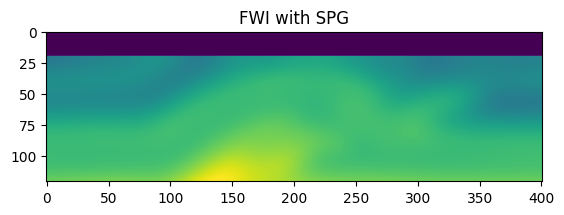

PyObject Text(0.5, 1.0, 'FWI with SPG')

In [ ]:
figure(); imshow(sqrt.(1f0./adjoint(model0.m))); title("FWI with SPG")

### fwi_example_minConf.jl

In [ ]:
# 2D FWI on Overthrust model with SPG using minConf library
# Author: Philipp Witte, pwitte@eoas.ubc.ca
# Date: December 2017
#

using Statistics, Random, LinearAlgebra, PyPlot
using JUDI.TimeModeling, JUDI.SLIM_optim, HDF5, SegyIO

# Load starting model
n,d,o,m0 = read(h5open("../../data/overthrust_model.h5","r"), "n", "d", "o", "m0")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0)

# Bound constraints
v0 = sqrt.(1f0 ./ model0.m)
vmin = ones(Float32,model0.n) .* 1.3f0
vmax = ones(Float32,model0.n) .* 6.5f0
vmin[:,1:21] .= v0[:,1:21]   # keep water column fixed
vmax[:,1:21] .= v0[:,1:21]

# Slowness squared [s^2/km^2]
mmin = vec((1f0 ./ vmax).^2)
mmax = vec((1f0 ./ vmin).^2)

# Load data
block = segy_read("../../data/overthrust_shot_records.segy")
d_obs = judiVector(block)

# Set up wavelet
src_geometry = Geometry(block; key="source")
wavelet = ricker_wavelet(src_geometry.t[1],src_geometry.dt[1],0.008f0)  # 8 Hz wavelet
q = judiVector(src_geometry,wavelet)

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=7076688, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /root/.julia/packages/SegyIO/uw4ZW/src/read/read_file.jl:26


judiVector{Float32}("Seismic data vector", 8016, 1, 16, GeometryIC(Any[400.0f0, 1013.333f0, 1626.667f0, 2240.0f0, 2853.333f0, 3466.666f0, 4080.0f0, 4693.334f0, 5306.666f0, 5920.0f0, 6533.334f0, 7146.666f0, 7760.0f0, 8373.333f0, 8986.667f0, 9600.0f0], Any[0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0], Any[50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0], Any[4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0], Any[501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501], Any[2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0]), Array[Float32[-0.00096925104; -0.0016848503; … ; -0.0; -0.0], Float32[-0.00096925104; -0.0016848503; … ; -0.0; -0.0], Float32[-0.00

In [ ]:
# Optimization parameters
fevals = 16
batchsize = 8

# Objective function for minConf library
count = 0
function objective_function(x)
    model0.m = reshape(x,model0.n);

    # fwi function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, grad = fwi_objective(model0, q[i], d_obs[i])
    grad = .125f0*grad/maximum(abs.(grad))  # scale for line search

    global count; count+= 1
    return fval, vec(grad)
end

# Bound projection
ProjBound(x) = median([mmin x mmax]; dims=2)

# FWI with SPG
options = spg_options(verbose=3, maxIter=fevals, memory=3)
sol = minConf_SPG(objective_function, vec(model0.m), ProjBound, options)

LoadError: ignored

In [ ]:
# Plot result
imshow(reshape(sqrt.(1f0 ./ sol.sol), model0.n)', extent=[0, 10, 3, 0])
xlabel("Lateral position [km]")
ylabel("Depth [km]")



---


# You can run this to check if Julia is running and its GPU perfomance




In [ ]:
VERSION

The main reason we are interested in running Julia on Colab is the GPU functionality. So we can benchmark the performance on the GPU.<br>**The next two cells are optional and are for people using it for the first time**

In [ ]:
using Pkg
Pkg.add(["BenchmarkTools", "CuArrays"])
using BenchmarkTools,CuArrays

In [ ]:
mcpu = rand(2^10, 2^10)
@benchmark mcpu*mcpu

println("The CuArrray operation should take around 1 ms(excluding CUDA downloading time which is a one time process), and should be much faster. If so, the GPU is working.")
mgpu = cu(mcpu)
@benchmark CuArrays.@sync mgpu*mgpu